In [1]:

!pip install -q transformers accelerate pillow scikit-learn pandas tqdm


In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# =========================
# Global Config
# =========================
BASE_DIR = "/content/drive/MyDrive/7015/vqa_rad"
PROCESSED_DIR = f"{BASE_DIR}/processed"
IMAGE_DIR = f"{BASE_DIR}/images"

TRAIN_CSV = f"{PROCESSED_DIR}/train_blip.csv"
VAL_CSV   = f"{PROCESSED_DIR}/val_blip.csv"
TEST_CSV  = f"{PROCESSED_DIR}/test_blip.csv"

TOPK_JSON = f"{PROCESSED_DIR}/topK_info.json"

SAVE_DIR = f"{BASE_DIR}/blip_finetune"
BEST_MODEL_PATH = f"{SAVE_DIR}/best_model.pt"
HISTORY_PATH = f"{SAVE_DIR}/training_history.pt"

import os
os.makedirs(SAVE_DIR, exist_ok=True)



In [4]:
import json

with open(TOPK_JSON) as f:
    topk_info = json.load(f)

answer_list = topk_info["topK"]
answer2id = {a: i for i, a in enumerate(answer_list)}
id2answer = {i: a for a, i in answer2id.items()}

NUM_ANSWERS = len(answer_list)
print("Number of answers:", NUM_ANSWERS)


Number of answers: 50


In [5]:
import json

TRAIN_JSON = f"{PROCESSED_DIR}/train_filtered.json"
VAL_JSON   = f"{PROCESSED_DIR}/val_filtered.json"

with open(TRAIN_JSON) as f:
    train_meta = json.load(f)

with open(VAL_JSON) as f:
    val_meta = json.load(f)

train_qid2type = {x["qid"]: x["question_type"] for x in train_meta}
val_qid2type   = {x["qid"]: x["question_type"] for x in val_meta}

print(list(train_qid2type.items())[:3])


[(970, 'MODALITY'), (1592, 'ABN'), (1735, 'PRES')]


In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image

class VQARAD_BLIP_Dataset_B(Dataset):
    def __init__(self, csv_path, qid2type, processor, answer2id):
        self.df = pd.read_csv(csv_path)
        self.qid2type = qid2type
        self.processor = processor
        self.answer2id = answer2id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        answer = row["answer"]
        if answer not in self.answer2id:
            return None

        image = Image.open(row["image_path"]).convert("RGB")

        encoding = self.processor(
            images=image,
            text=row["question"],
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )

        qid = row.get("qid", idx)

        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.answer2id[answer]),
            "qid": qid,
            "question_type": self.qid2type.get(qid, "unknown")
        }


In [7]:
from torch.utils.data import default_collate

def collate_fn_skip_none(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return default_collate(batch)


In [8]:
from torch.utils.data import DataLoader
from transformers import BlipProcessor

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

train_dataset = VQARAD_BLIP_Dataset_B(
    TRAIN_CSV, train_qid2type, processor, answer2id
)

val_dataset = VQARAD_BLIP_Dataset_B(
    VAL_CSV, val_qid2type, processor, answer2id
)

train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True,
    collate_fn=collate_fn_skip_none
)

val_loader = DataLoader(
    val_dataset, batch_size=8,
    collate_fn=collate_fn_skip_none
)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [9]:
import torch.nn as nn
from transformers import BlipModel

class BLIP_VQA_Classifier(nn.Module):
    def __init__(self, num_answers):
        super().__init__()
        self.blip = BlipModel.from_pretrained("Salesforce/blip-vqa-base")
        self.classifier = nn.Linear(
            self.blip.config.text_config.hidden_size,
            num_answers
        )

    def forward(self, pixel_values, input_ids, attention_mask, labels=None):
      outputs = self.blip(
        pixel_values=pixel_values,
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=True
    )


      pooled = outputs.text_model_output.last_hidden_state[:, 0, :]

      logits = self.classifier(pooled)

      loss = None
      if labels is not None:
        loss = nn.CrossEntropyLoss()(logits, labels)

      return loss, logits




In [10]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


model = BLIP_VQA_Classifier(NUM_ANSWERS)


#for param in model.blip.parameters():
    #param.requires_grad = False

print("BLIP backbone frozen. Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


model = model.to(device)


optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-5
)



config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-vqa-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.l

BLIP backbone frozen. Trainable parameters:
blip.logit_scale
blip.text_model.embeddings.word_embeddings.weight
blip.text_model.embeddings.position_embeddings.weight
blip.text_model.embeddings.LayerNorm.weight
blip.text_model.embeddings.LayerNorm.bias
blip.text_model.encoder.layer.0.attention.self.query.weight
blip.text_model.encoder.layer.0.attention.self.query.bias
blip.text_model.encoder.layer.0.attention.self.key.weight
blip.text_model.encoder.layer.0.attention.self.key.bias
blip.text_model.encoder.layer.0.attention.self.value.weight
blip.text_model.encoder.layer.0.attention.self.value.bias
blip.text_model.encoder.layer.0.attention.output.dense.weight
blip.text_model.encoder.layer.0.attention.output.dense.bias
blip.text_model.encoder.layer.0.attention.output.LayerNorm.weight
blip.text_model.encoder.layer.0.attention.output.LayerNorm.bias
blip.text_model.encoder.layer.0.crossattention.self.query.weight
blip.text_model.encoder.layer.0.crossattention.self.query.bias
blip.text_model.enc

In [11]:
SAVE_DIR = "/content/drive/MyDrive/7015/vqa_rad/BLIP"
os.makedirs(SAVE_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(SAVE_DIR, "best_blip_model2.pt")
HISTORY_PATH    = os.path.join(SAVE_DIR, "train_history2.pt")


In [12]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import torch
import numpy as np
from torch.amp import autocast, GradScaler

# =========================
# Basic setup
# =========================
device = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5
best_val_acc = 0.0
scaler = GradScaler('cuda')

history = {
    "train_loss": [],
    "val_acc": [],
    "macro_f1": [],
    "weighted_f1": []
}

# =========================
# Training loop
# =========================
for epoch in range(EPOCHS):

    # =========================
    # Training
    # =========================
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        if batch is None:
            continue

        optimizer.zero_grad()

        with autocast("cuda"):
            loss, _ = model(
                batch["pixel_values"].to(device),
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device)
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)

    # =========================
    # Validation
    # =========================
    model.eval()

    all_preds = []
    all_labels = []
    all_qtypes = []

    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue

            _, logits = model(
                batch["pixel_values"].to(device),
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )

            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)
            all_qtypes.extend(batch["question_type"])

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    val_acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")

    history["val_acc"].append(val_acc)
    history["macro_f1"].append(macro_f1)
    history["weighted_f1"].append(weighted_f1)

    print(
        f"Epoch {epoch+1} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Acc: {val_acc:.4f} | "
        f"Macro F1: {macro_f1:.4f} | "
        f"Weighted F1: {weighted_f1:.4f}"
    )

    # =========================
    # Save best model
    torch.save(history, HISTORY_PATH)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"Best model saved (val_acc={val_acc:.4f})")


Epoch 1 Training:   1%|          | 2/197 [00:06<11:07,  3.43s/it]


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# =========================
# Load best model
# =========================
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()

all_preds = []
all_labels = []
all_qtypes = []

with torch.no_grad():
    for batch in val_loader:
        if batch is None:
            continue

        _, logits = model(
            batch["pixel_values"].to(device),
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )

        preds = logits.argmax(dim=1).cpu().numpy()
        labels = batch["labels"].cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)
        all_qtypes.extend(batch["question_type"])

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# =========================
# Map question_type → OPEN / CLOSED
# =========================
CLOSED_TYPES = {"MODALITY", "ABN", "PRES"}

all_oc_types = np.array(
    ["CLOSED" if qt in CLOSED_TYPES else "OPEN" for qt in all_qtypes]
)

# =========================
# Final Open / Closed results
# =========================
print("===== Final Open / Closed Evaluation (Validation Set) =====")

for split in ["OPEN", "CLOSED"]:
    mask = all_oc_types == split

    if mask.sum() == 0:
        print(f"{split} QUESTIONS: none")
        continue

    acc = accuracy_score(all_labels[mask], all_preds[mask])
    macro_f1 = f1_score(all_labels[mask], all_preds[mask], average="macro")
    weighted_f1 = f1_score(all_labels[mask], all_preds[mask], average="weighted")

    print(
        f"{split} QUESTIONS | "
        f"Acc: {acc:.4f} | "
        f"Macro F1: {macro_f1:.4f} | "
        f"Weighted F1: {weighted_f1:.4f}"
    )


===== Final Open / Closed Evaluation (Validation Set) =====
OPEN QUESTIONS | Acc: 0.6131 | Macro F1: 0.2670 | Weighted F1: 0.6029
CLOSED QUESTIONS | Acc: 0.6000 | Macro F1: 0.3333 | Weighted F1: 0.6000


In [13]:
import torch
import matplotlib.pyplot as plt

HISTORY_PATH = "/content/drive/MyDrive/7015/vqa_rad/BLIP/train_history2.pt"

history = torch.load(HISTORY_PATH)

train_loss  = history["train_loss"]
val_acc     = history["val_acc"]
macro_f1    = history["macro_f1"]
weighted_f1 = history["weighted_f1"]

epochs = range(1, len(train_loss) + 1)

print("Loaded epochs:", len(train_loss))


Loaded epochs: 5


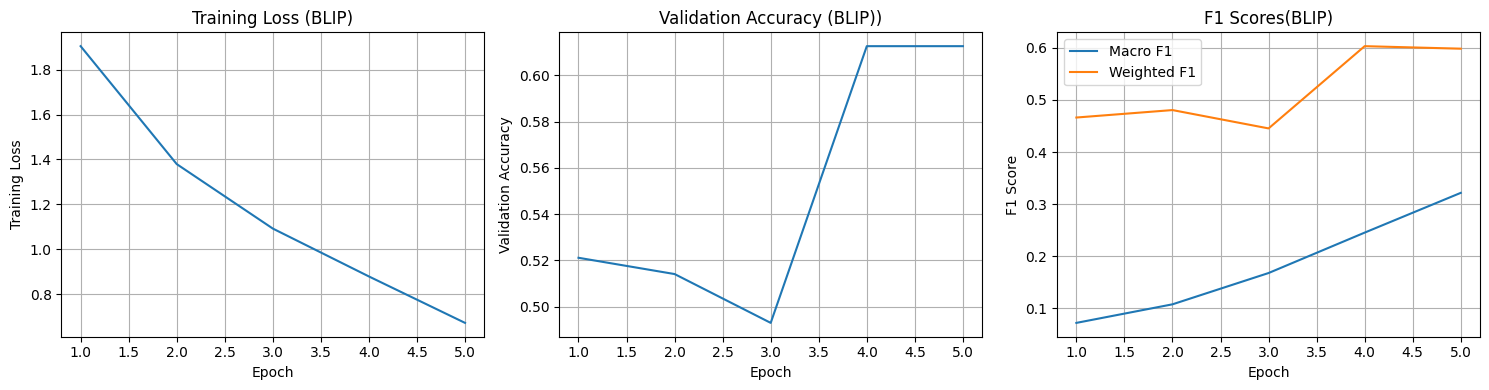

In [14]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(epochs, train_loss)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss (BLIP)")
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(epochs, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy (BLIP))")
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(epochs, macro_f1, label="Macro F1")
plt.plot(epochs, weighted_f1, label="Weighted F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Scores(BLIP)")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


In [15]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = BLIP_VQA_Classifier(NUM_ANSWERS)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print("✅ Best model loaded")


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-vqa-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.l

✅ Best model loaded


In [16]:

qid2item = {item["qid"]: item for item in val_meta}

print("Example qid:", list(qid2item.keys())[:5])


Example qid: [1106, 654, 556, 480, 1461]


In [17]:
import os

IMAGE_ROOT = "/content/drive/MyDrive/7015/vqa_rad/VQA_RAD Image Folder"


In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os

def predict_by_qid(qid):
    """
    Predict answer for a given QID using the fine-tuned BLIP model.
    This function:
    - loads the image using image_file + IMAGE_ROOT
    - runs BLIP inference
    - displays the image
    - prints question, GT answer, predicted answer
    - correctly distinguishes OPEN vs CLOSED questions
    """

    model.eval()

    # ================================
    # 1. Retrieve metadata from JSON
    # ================================
    assert qid in qid2item, f"QID {qid} not found in val_filtered.json"
    item = qid2item[qid]

    image_file    = item["image_file"]      # filename only (e.g. synpic123.jpg)
    image_path    = os.path.join(IMAGE_ROOT, image_file)
    question      = item["question"]
    gt_answer     = item["answer"]
    question_type = item["question_type"]   # e.g. ORGAN / ABN / MODALITY
    answer_type   = item["answer_type"]     # OPEN or CLOSED

    assert os.path.exists(image_path), f"Image not found: {image_path}"

    # ================================
    # 2. Load image
    # ================================
    image = Image.open(image_path).convert("RGB")

    # ================================
    # 3. Model inference
    # ================================
    encoding = processor(
        images=image,
        text=question,
        return_tensors="pt",
        padding="max_length",
        truncation=True
    )

    encoding = {k: v.to(device) for k, v in encoding.items()}

    with torch.no_grad():
        _, logits = model(
            encoding["pixel_values"],
            encoding["input_ids"],
            encoding["attention_mask"]
        )

        pred_id = logits.argmax(dim=1).item()
        pred_answer = id2answer[pred_id]

    # ================================
    # 4. Display image
    # ================================
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"QID {qid} | {answer_type} question", fontsize=12)
    plt.show()

    # ================================
    # 5. Print results
    # ================================
    print("=" * 45)
    print(f"QID           : {qid}")
    print(f"Question Type : {question_type}")
    print(f"Answer Type   : {answer_type}")
    print(f"Question      : {question}")
    print(f"GT Answer     : {gt_answer}")
    print(f"Pred Answer   : {pred_answer}")
    print("=" * 45)


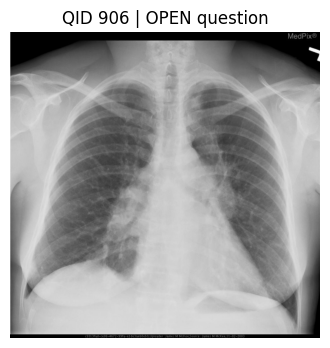

QID           : 906
Question Type : PLANE
Answer Type   : OPEN
Question      : What plane is this X-ray in?
GT Answer     : pa
Pred Answer   : axial


In [ ]:

predict_by_qid(906)
